# Dimensional Aspect-Based Sentiment Analysis (DimABSA)
## SemEval-2026 Task 3, Subtask 1: DeBERTa-based Implementation with Lexicon Integration

---

This notebook implements the complete methodology from the project proposal:

1. **Data Loading**: Load and explore DimABSA2026 dataset
2. **Lexicon Integration**: NRC VAD Lexicon for sentiment features
3. **Main Model**: DeBERTa-V3 with aspect attention and cross-attention
4. **Baselines**: Lexicon-only, BERT, RoBERTa, Simplified DeBERTa
5. **Training & Evaluation**: Complete pipeline with metrics
6. **Analysis**: Comparison and visualization

**Authors**: Anıl Dervişoğlu, Ömer Faruk Zeybek  
**Course**: Deep Learning, Istanbul Technical University

## 1. Setup and Imports

In [21]:
# Install required packages (run this cell first!)
# DeBERTa-v3 requires sentencepiece, protobuf, and tiktoken for tokenization

import subprocess
import sys

def install_if_missing(package, import_name=None):
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

# Required for DeBERTa-v3 tokenizer
install_if_missing("sentencepiece")
install_if_missing("protobuf")
install_if_missing("tiktoken")

# Other required packages
install_if_missing("transformers")
install_if_missing("torch")
install_if_missing("pandas")
install_if_missing("numpy")
install_if_missing("scipy")
install_if_missing("scikit-learn", "sklearn")
install_if_missing("tqdm")
install_if_missing("matplotlib")
install_if_missing("seaborn")

print("All required packages installed!")

Installing protobuf...
All required packages installed!


In [22]:
import os
import sys
from pathlib import Path
import json
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Transformers
from transformers import AutoTokenizer, AutoModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set project root
PROJECT_ROOT = Path("..")
sys.path.insert(0, str(PROJECT_ROOT))

# Import our modules
from src.data_loader import (
    load_dimabsa_dataset, 
    AspectAwareDataset, 
    create_dataloaders,
    get_dataset_statistics
)
from src.lexicon import NRCVADLexicon, LexiconOnlyPredictor
from src.models.deberta_dimabsa import DeBERTaDimABSA, DeBERTaDimABSAConfig
from src.models.baselines import (
    BERTDimABSA, 
    RoBERTaDimABSA, 
    SimplifiedDeBERTa,
    TransformerVARegressor
)
from src.trainer import (
    DimABSATrainer, 
    TrainingConfig, 
    compute_metrics,
    train_model,
    evaluate_model
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cpu


In [23]:
# Configuration
DATA_DIR = PROJECT_ROOT / "DimABSA2026" / "task-dataset" / "track_a" / "subtask_1"
LEXICON_DIR = PROJECT_ROOT / "NRC-VAD-Lexicon-v2.1"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

OUTPUT_DIR.mkdir(exist_ok=True)

# Training settings
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5  # Reduce for faster iteration
EARLY_STOPPING_PATIENCE = 3

print(f"Data directory: {DATA_DIR.resolve()}")
print(f"Lexicon directory: {LEXICON_DIR.resolve()}")
print(f"Output directory: {OUTPUT_DIR.resolve()}")

Data directory: C:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\DimABSA2026\task-dataset\track_a\subtask_1
Lexicon directory: C:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\NRC-VAD-Lexicon-v2.1
Output directory: C:\Users\omerf\Desktop\Deep Learning\Project\DimABSA\outputs


## 2. Data Exploration

Let's load and explore the DimABSA dataset.

In [24]:
# Load restaurant and laptop datasets
print("Loading datasets...")

restaurant_data = load_dimabsa_dataset(
    DATA_DIR, lang="eng", domain="restaurant", 
    split_dev=True, dev_size=0.1
)

laptop_data = load_dimabsa_dataset(
    DATA_DIR, lang="eng", domain="laptop",
    split_dev=True, dev_size=0.1
)

print(f"\nRestaurant Dataset:")
for split, df in restaurant_data.items():
    print(f"  {split}: {len(df)} samples")

print(f"\nLaptop Dataset:")
for split, df in laptop_data.items():
    print(f"  {split}: {len(df)} samples")

Loading datasets...

Restaurant Dataset:
  train: 2796 samples
  dev: 311 samples
  test: 340 samples

Laptop Dataset:
  train: 4462 samples
  dev: 496 samples
  test: 275 samples


In [25]:
# Dataset statistics
print("\n" + "="*60)
print("RESTAURANT DATASET STATISTICS")
print("="*60)
stats = get_dataset_statistics(restaurant_data['train'])
for key, value in stats.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

print("\n" + "="*60)
print("LAPTOP DATASET STATISTICS")
print("="*60)
stats = get_dataset_statistics(laptop_data['train'])
for key, value in stats.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")


RESTAURANT DATASET STATISTICS
  num_samples: 2796
  num_unique_texts: 2109
  avg_aspects_per_text: 1.33
  valence_mean: 6.24
  valence_std: 1.79
  valence_min: 1.17
  valence_max: 9.00
  arousal_mean: 6.81
  arousal_std: 1.15
  arousal_min: 3.83
  arousal_max: 9.00
  avg_text_length: 80.86
  avg_aspect_length: 7.45

LAPTOP DATASET STATISTICS
  num_samples: 4462
  num_unique_texts: 3738
  avg_aspects_per_text: 1.19
  valence_mean: 5.85
  valence_std: 1.78
  valence_min: 1.00
  valence_max: 8.83
  arousal_mean: 6.62
  arousal_std: 1.05
  arousal_min: 3.83
  arousal_max: 8.83
  avg_text_length: 80.46
  avg_aspect_length: 7.89


In [26]:
# Sample data
print("\nSample Restaurant Data:")
display(restaurant_data['train'].head(5))

print("\nSample Laptop Data:")
display(laptop_data['train'].head(5))


Sample Restaurant Data:



Sample Restaurant Data:


,ID,Text,Aspect,Valence,Arousal
0,rest16_quad_test_127,seattle ' s best winelist,winelist,8.25,8.38
1,rest16_quad_train_814,"the restaurant has a family feel , not least w...",veal,5.67,5.33
2,rest16_quad_train_1157,"service ok but unfriendly , filthy bathroom .",bathroom,3.33,5.83
3,rest16_quad_test_222,best crab cakes in town,crab cakes,6.88,6.50
4,rest16_quad_train_781,they are not helpful in the least and will giv...,NULL,3.17,7.00



Sample Restaurant Data:


,ID,Text,Aspect,Valence,Arousal
0,rest16_quad_test_127,seattle ' s best winelist,winelist,8.25,8.38
1,rest16_quad_train_814,"the restaurant has a family feel , not least w...",veal,5.67,5.33
2,rest16_quad_train_1157,"service ok but unfriendly , filthy bathroom .",bathroom,3.33,5.83
3,rest16_quad_test_222,best crab cakes in town,crab cakes,6.88,6.50
4,rest16_quad_train_781,they are not helpful in the least and will giv...,NULL,3.17,7.00



Sample Laptop Data:


,ID,Text,Aspect,Valence,Arousal
0,laptop_quad_dev_190,"if i had it to do over , i would not purchase ...",computer,3.10,6.30
1,laptop_quad_train_2141,after charging the unit for 2 hours i discover...,unit,4.75,5.25
2,laptop_quad_dev_253,"freezes with red lines across it , froze five ...",NULL,2.00,7.67
3,laptop_quad_train_1230,a wonderful device with extremely clear display .,device,8.00,7.83
4,laptop_quad_test_236,the screen does look good .,screen,6.62,6.62


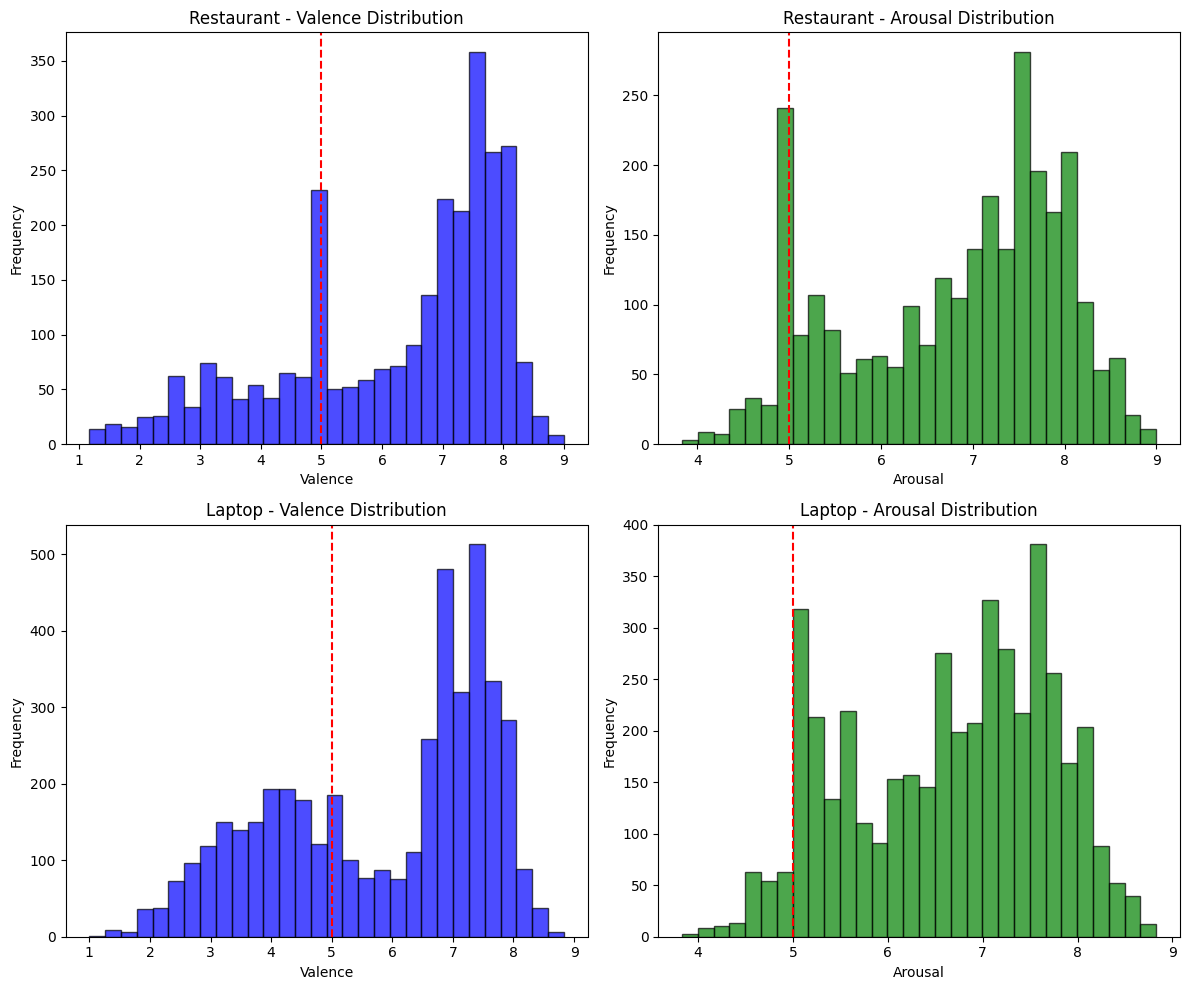

In [27]:
# Visualize VA distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Restaurant
axes[0, 0].hist(restaurant_data['train']['Valence'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_xlabel('Valence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Restaurant - Valence Distribution')
axes[0, 0].axvline(5, color='red', linestyle='--', label='Neutral')

axes[0, 1].hist(restaurant_data['train']['Arousal'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Arousal')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Restaurant - Arousal Distribution')
axes[0, 1].axvline(5, color='red', linestyle='--', label='Neutral')

# Laptop
axes[1, 0].hist(laptop_data['train']['Valence'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Laptop - Valence Distribution')
axes[1, 0].axvline(5, color='red', linestyle='--', label='Neutral')

axes[1, 1].hist(laptop_data['train']['Arousal'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].set_xlabel('Arousal')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Laptop - Arousal Distribution')
axes[1, 1].axvline(5, color='red', linestyle='--', label='Neutral')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'va_distribution.png', dpi=150)
plt.show()

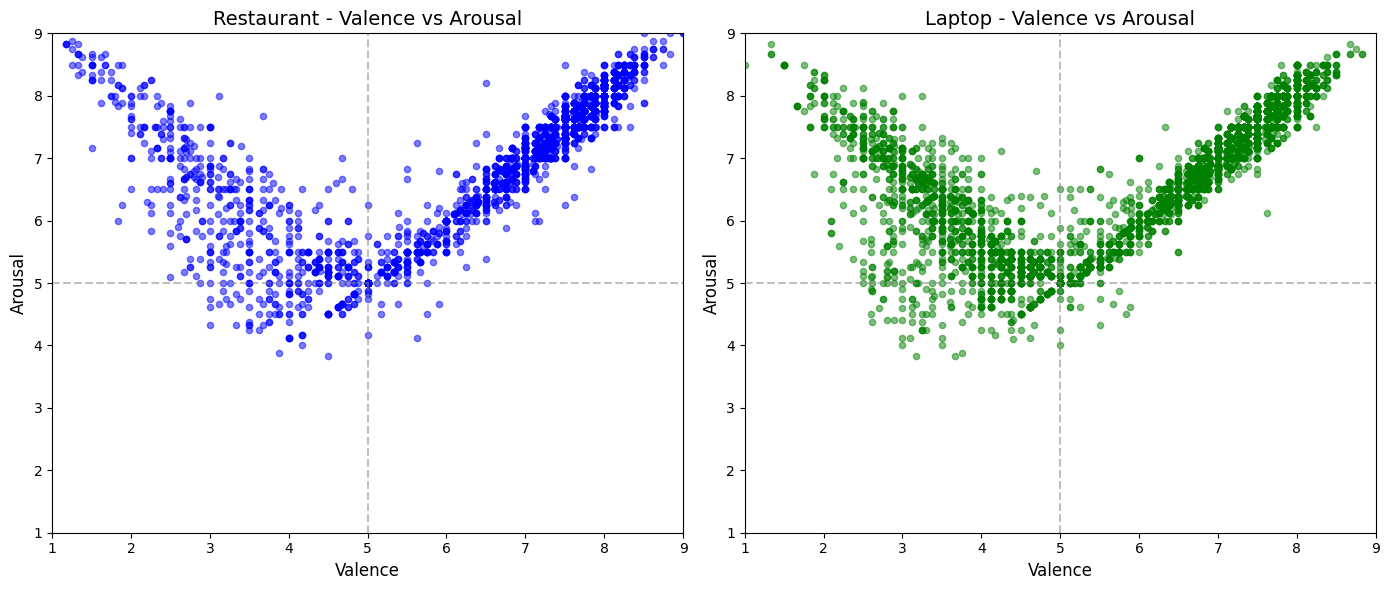

In [28]:
# VA scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Restaurant
scatter1 = axes[0].scatter(
    restaurant_data['train']['Valence'], 
    restaurant_data['train']['Arousal'],
    alpha=0.5, c='blue', s=20
)
axes[0].set_xlabel('Valence', fontsize=12)
axes[0].set_ylabel('Arousal', fontsize=12)
axes[0].set_title('Restaurant - Valence vs Arousal', fontsize=14)
axes[0].axhline(5, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(5, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlim(1, 9)
axes[0].set_ylim(1, 9)

# Laptop
scatter2 = axes[1].scatter(
    laptop_data['train']['Valence'], 
    laptop_data['train']['Arousal'],
    alpha=0.5, c='green', s=20
)
axes[1].set_xlabel('Valence', fontsize=12)
axes[1].set_ylabel('Arousal', fontsize=12)
axes[1].set_title('Laptop - Valence vs Arousal', fontsize=14)
axes[1].axhline(5, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlim(1, 9)
axes[1].set_ylim(1, 9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'va_scatter.png', dpi=150)
plt.show()

## 3. NRC VAD Lexicon Integration

Load the NRC VAD Lexicon and demonstrate feature extraction.

In [29]:
# Load lexicon
lexicon_path = LEXICON_DIR / "NRC-VAD-Lexicon-v2.1.txt"
print(f"Loading lexicon from: {lexicon_path}")

lexicon = NRCVADLexicon(
    lexicon_path=lexicon_path,
    convert_scale=True,  # Convert [-1,1] to [1,9]
    use_dependency_parsing=False  # Use window-based for simplicity
)

print(f"Lexicon loaded with {len(lexicon.lexicon)} terms")

Loading lexicon from: ..\NRC-VAD-Lexicon-v2.1\NRC-VAD-Lexicon-v2.1.txt
Loaded 54801 terms from NRC VAD Lexicon
Lexicon loaded with 54801 terms


In [30]:
# Test word lookup
test_words = [
    "excellent", "terrible", "good", "bad", "amazing", 
    "horrible", "love", "hate", "delicious", "disgusting",
    "laptop", "food", "service", "battery", "screen"
]

print("Word VA Scores (converted to 1-9 scale):")
print("-" * 45)
print(f"{'Word':<15} {'Valence':>10} {'Arousal':>10}")
print("-" * 45)

for word in test_words:
    va = lexicon.get_word_va(word)
    if va:
        print(f"{word:<15} {va[0]:>10.2f} {va[1]:>10.2f}")
    else:
        print(f"{word:<15} {'N/A':>10} {'N/A':>10}")

Word VA Scores (converted to 1-9 scale):
---------------------------------------------
Word               Valence    Arousal
---------------------------------------------
excellent             8.76       5.70
terrible              1.49       7.79
good                  8.50       3.94
bad                   2.00       6.00
amazing               8.25       7.70
horrible              1.57       7.86
love                  8.98       6.34
hate                  1.25       7.42
delicious             8.42       6.20
disgusting            1.25       7.37
laptop                6.79       3.16
food                  8.10       3.59
service               6.47       4.26
battery               4.84       4.40
screen                6.36       3.40


In [31]:
# Feature extraction demo
test_cases = [
    ("The food was absolutely amazing and delicious!", "food"),
    ("Terrible service, the waiter was rude and slow.", "service"),
    ("The laptop battery drains way too quickly.", "battery"),
    ("I love this screen, it's bright and clear!", "screen"),
    ("Average experience, nothing special about the place.", "place"),
]

print("\nLexicon Feature Extraction Demo:")
print("="*80)

feature_names = ['ctx_v', 'ctx_a', 'asp_v', 'asp_a', 'wgt_v', 'wgt_a', 'max_v', 'max_a']

for text, aspect in test_cases:
    features = lexicon.extract_features(text, aspect)
    print(f"\nText: {text}")
    print(f"Aspect: {aspect}")
    print(f"Features: {dict(zip(feature_names, features.numpy().round(2)))}")


Lexicon Feature Extraction Demo:

Text: The food was absolutely amazing and delicious!
Aspect: food
Features: {'ctx_v': np.float32(6.51), 'ctx_a': np.float32(5.74), 'asp_v': np.float32(8.1), 'asp_a': np.float32(3.59), 'wgt_v': np.float32(6.16), 'wgt_a': np.float32(5.52), 'max_v': np.float32(8.42), 'max_a': np.float32(7.7)}

Text: Terrible service, the waiter was rude and slow.
Aspect: service
Features: {'ctx_v': np.float32(3.53), 'ctx_a': np.float32(5.69), 'asp_v': np.float32(6.47), 'asp_a': np.float32(4.26), 'wgt_v': np.float32(3.23), 'wgt_a': np.float32(5.89), 'max_v': np.float32(5.0), 'max_a': np.float32(7.79)}

Text: The laptop battery drains way too quickly.
Aspect: battery
Features: {'ctx_v': np.float32(5.98), 'ctx_a': np.float32(4.93), 'asp_v': np.float32(4.84), 'asp_a': np.float32(4.4), 'wgt_v': np.float32(6.01), 'wgt_a': np.float32(4.34), 'max_v': np.float32(7.27), 'max_a': np.float32(8.38)}

Text: I love this screen, it's bright and clear!
Aspect: screen
Features: {'ctx_v': 

In [32]:
# Test lexicon-only predictor (Baseline 1)
lexicon_predictor = LexiconOnlyPredictor(
    lexicon=lexicon,
    context_weight=0.3,
    aspect_weight=0.7
)

print("\nLexicon-Only Baseline Predictions:")
print("="*60)

for text, aspect in test_cases:
    v, a = lexicon_predictor.predict(text, aspect)
    print(f"Aspect: '{aspect}' -> V={v:.2f}, A={a:.2f}")


Lexicon-Only Baseline Predictions:
Aspect: 'food' -> V=7.52, A=4.17
Aspect: 'service' -> V=5.50, A=4.75
Aspect: 'battery' -> V=5.19, A=4.38
Aspect: 'screen' -> V=6.35, A=3.83
Aspect: 'place' -> V=5.68, A=3.52


## 4. Model Implementation

### 4.1 Initialize Tokenizer and Data Loaders

In [33]:
# Select domain for training (can be 'restaurant' or 'laptop')
DOMAIN = 'laptop'

if DOMAIN == 'laptop':
    train_df = restaurant_data['train']
    dev_df = restaurant_data['dev']
else:
    train_df = laptop_data['train']
    dev_df = laptop_data['dev']
    
print(f"Training domain: {DOMAIN}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(dev_df)}")

Training domain: laptop
Training samples: 2796
Validation samples: 311


In [34]:
# Initialize tokenizer (DeBERTa)
MODEL_NAME = "microsoft/deberta-v3-base"
print(f"Loading tokenizer: {MODEL_NAME}")

try:
    # Try fast tokenizer first
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Fast tokenizer failed, trying slow tokenizer: {e}")
    # Fall back to slow tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Tokenizer type: {type(tokenizer).__name__}")

Loading tokenizer: microsoft/deberta-v3-base
Vocabulary size: 128000
Tokenizer type: DebertaV2TokenizerFast


In [35]:
# Create data loaders with aspect-aware tokenization
train_loader, dev_loader = create_dataloaders(
    train_df=train_df,
    dev_df=dev_df,
    tokenizer=tokenizer,
    batch_size=BATCH_SIZE,
    max_length=MAX_LENGTH,
    use_aspect_aware=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(dev_loader)}")

Training batches: 175
Validation batches: 20


In [36]:
# Save artifacts (train/dev/tokenizer) so other notebooks can load them if not using the same kernel
artifacts_dir = OUTPUT_DIR / 'artifacts'
artifacts_dir.mkdir(parents=True, exist_ok=True)
# Save dataframes (pickle)
train_df.to_pickle(artifacts_dir / 'train_df.pkl')
dev_df.to_pickle(artifacts_dir / 'dev_df.pkl')
# Save tokenizer (transformers format)
try:
    tokenizer.save_pretrained(str(artifacts_dir / 'tokenizer'))
    print('Saved tokenizer and dataframes to', artifacts_dir)
except NameError:
    print('Tokenizer not found in this scope. If you run tokenizer cell later, re-run this save cell.')

Saved tokenizer and dataframes to ..\outputs\artifacts


In [37]:
# Inspect a batch
batch = next(iter(train_loader))
print("Batch contents:")
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"  {key}: {value.shape}")
    else:
        print(f"  {key}: {type(value).__name__} of length {len(value)}")

Batch contents:
  input_ids: torch.Size([16, 128])
  attention_mask: torch.Size([16, 128])
  token_type_ids: torch.Size([16, 128])
  aspect_mask: torch.Size([16, 128])
  labels: torch.Size([16, 2])
  text: list of length 16
  aspect: list of length 16


### 4.2 Create Lexicon Feature Extractor

In [38]:
# Create lexicon feature extractor function for training
def lexicon_feature_extractor(texts, aspects):
    """Extract lexicon features for a batch."""
    return lexicon.extract_batch_features(texts, aspects)

# Test
sample_texts = [batch['text'][0], batch['text'][1]]
sample_aspects = [batch['aspect'][0], batch['aspect'][1]]
sample_features = lexicon_feature_extractor(sample_texts, sample_aspects)
print(f"Sample lexicon features shape: {sample_features.shape}")

Sample lexicon features shape: torch.Size([2, 8])


### 4.3 Initialize Models

In [39]:
# Main model: DeBERTa with attention and lexicon
print("Initializing main model: DeBERTaDimABSA")

main_config = DeBERTaDimABSAConfig(
    model_name=MODEL_NAME,
    use_lexicon=True,
    lexicon_feature_dim=8,
    num_attention_heads=8,
    head_hidden_size=256,
    num_head_layers=2,
    head_dropout=0.1,
    output_scaling="sigmoid"
)

main_model = DeBERTaDimABSA(main_config)
print(f"Main model parameters: {main_model.get_num_params():,} trainable")

Initializing main model: DeBERTaDimABSA
Main model parameters: 192,629,763 trainable


In [40]:
# Baseline: Simplified DeBERTa (no attention, no lexicon)
print("\nInitializing Simplified DeBERTa baseline")

simplified_model = SimplifiedDeBERTa(
    model_name=MODEL_NAME,
    hidden_size=256,
    dropout=0.1,
    output_scaling="sigmoid"
)
print(f"Simplified model parameters: {simplified_model.get_num_params():,} trainable")


Initializing Simplified DeBERTa baseline
Simplified model parameters: 183,833,090 trainable


In [41]:
# Optional: BERT baseline
print("\nInitializing BERT baseline")

bert_model = BERTDimABSA(
    model_name="bert-base-uncased",
    pooling="cls",
    hidden_size=256,
    dropout=0.1
)
print(f"BERT model parameters: {bert_model.get_num_params():,} trainable")


Initializing BERT baseline
BERT model parameters: 109,876,482 trainable


## 5. Training

### 5.1 Train Main Model (DeBERTa + Attention + Lexicon)

In [66]:
# Training configuration
training_config = TrainingConfig(
    learning_rate=LEARNING_RATE,
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    gradient_clip_norm=1.0,
    scheduler_type="linear",
    warmup_ratio=0.1,
    checkpoint_dir=str(OUTPUT_DIR / "checkpoints"),
    device=str(device)
)

print("Training configuration:")
print(f"  Learning rate: {training_config.learning_rate}")
print(f"  Epochs: {training_config.num_epochs}")
print(f"  Early stopping patience: {training_config.early_stopping_patience}")
print(f"  Device: {training_config.device}")

Training configuration:
  Learning rate: 2e-05
  Epochs: 5
  Early stopping patience: 3
  Device: cpu


In [67]:
# Train main model
print("="*60)
print("TRAINING MAIN MODEL: DeBERTa + Attention + Lexicon")
print("="*60)

main_trainer = DimABSATrainer(
    model=main_model,
    config=training_config,
    lexicon_extractor=lexicon_feature_extractor
)

main_results = main_trainer.train(
    train_loader=train_loader,
    eval_loader=dev_loader,
    model_name=f"deberta_dimabsa_{DOMAIN}"
)

TRAINING MAIN MODEL: DeBERTa + Attention + Lexicon

Starting training: deberta_dimabsa_laptop
  Device: cpu
  Epochs: 5
  Learning rate: 2e-05
  Training samples: 2796
  Validation samples: 311



Epoch 1/5: 100%|██████████| 175/175 [36:24<00:00, 12.48s/it, loss=1.4941, avg_loss=2.7943]



Epoch 1 Results:
  Train Loss: 2.7943
  Val Loss: 2.2907
  Val RMSE_VA: 1.5103
  Val PCC_V: 0.8185
  Val PCC_A: 0.5770
  -> New best model saved! (rmse_va: 1.5103)


Epoch 2/5: 100%|██████████| 175/175 [30:04<00:00, 10.31s/it, loss=1.7209, avg_loss=1.5311]



Epoch 2 Results:
  Train Loss: 1.5311
  Val Loss: 1.5851
  Val RMSE_VA: 1.2593
  Val PCC_V: 0.8758
  Val PCC_A: 0.6601
  -> New best model saved! (rmse_va: 1.2593)


Epoch 3/5: 100%|██████████| 175/175 [31:03<00:00, 10.65s/it, loss=0.5169, avg_loss=1.0816]



Epoch 3 Results:
  Train Loss: 1.0816
  Val Loss: 1.3623
  Val RMSE_VA: 1.1684
  Val PCC_V: 0.8934
  Val PCC_A: 0.7138
  -> New best model saved! (rmse_va: 1.1684)


Epoch 4/5: 100%|██████████| 175/175 [32:58<00:00, 11.31s/it, loss=0.4570, avg_loss=0.8302]



Epoch 4 Results:
  Train Loss: 0.8302
  Val Loss: 1.3748
  Val RMSE_VA: 1.1738
  Val PCC_V: 0.8931
  Val PCC_A: 0.7326
  -> No improvement (1/3)


Epoch 5/5: 100%|██████████| 175/175 [29:54<00:00, 10.26s/it, loss=0.3178, avg_loss=0.6772]



Epoch 5 Results:
  Train Loss: 0.6772
  Val Loss: 1.3309
  Val RMSE_VA: 1.1571
  Val PCC_V: 0.8976
  Val PCC_A: 0.7335
  -> New best model saved! (rmse_va: 1.1571)

Training completed in 9971.7s
Best epoch: 5
Best rmse_va: 1.1571



### 5.2 Train Simplified Baseline (DeBERTa without attention/lexicon)

In [68]:
# Train simplified baseline
print("="*60)
print("TRAINING BASELINE: Simplified DeBERTa")
print("="*60)

simplified_trainer = DimABSATrainer(
    model=simplified_model,
    config=training_config,
    lexicon_extractor=None  # No lexicon
)

simplified_results = simplified_trainer.train(
    train_loader=train_loader,
    eval_loader=dev_loader,
    model_name=f"simplified_deberta_{DOMAIN}"
)

TRAINING BASELINE: Simplified DeBERTa

Starting training: simplified_deberta_laptop
  Device: cpu
  Epochs: 5
  Learning rate: 2e-05
  Training samples: 2796
  Validation samples: 311



Epoch 1/5: 100%|██████████| 175/175 [30:24<00:00, 10.42s/it, loss=2.8359, avg_loss=2.7470]



Epoch 1 Results:
  Train Loss: 2.7470
  Val Loss: 1.6226
  Val RMSE_VA: 1.2680
  Val PCC_V: 0.8704
  Val PCC_A: 0.6498
  -> New best model saved! (rmse_va: 1.2680)


Epoch 2/5: 100%|██████████| 175/175 [29:18<00:00, 10.05s/it, loss=1.4443, avg_loss=1.5165]



Epoch 2 Results:
  Train Loss: 1.5165
  Val Loss: 1.5979
  Val RMSE_VA: 1.2570
  Val PCC_V: 0.8920
  Val PCC_A: 0.7065
  -> New best model saved! (rmse_va: 1.2570)


Epoch 3/5: 100%|██████████| 175/175 [29:29<00:00, 10.11s/it, loss=0.6082, avg_loss=1.1100]



Epoch 3 Results:
  Train Loss: 1.1100
  Val Loss: 1.2779
  Val RMSE_VA: 1.1306
  Val PCC_V: 0.9003
  Val PCC_A: 0.7485
  -> New best model saved! (rmse_va: 1.1306)


Epoch 4/5: 100%|██████████| 175/175 [34:27<00:00, 11.82s/it, loss=1.3958, avg_loss=0.8121]



Epoch 4 Results:
  Train Loss: 0.8121
  Val Loss: 1.2603
  Val RMSE_VA: 1.1186
  Val PCC_V: 0.9125
  Val PCC_A: 0.7696
  -> New best model saved! (rmse_va: 1.1186)


Epoch 5/5: 100%|██████████| 175/175 [38:12<00:00, 13.10s/it, loss=0.4232, avg_loss=0.6724]



Epoch 5 Results:
  Train Loss: 0.6724
  Val Loss: 1.1911
  Val RMSE_VA: 1.0940
  Val PCC_V: 0.9113
  Val PCC_A: 0.7704
  -> New best model saved! (rmse_va: 1.0940)

Training completed in 10033.1s
Best epoch: 5
Best rmse_va: 1.0940



### 5.3 Evaluate Lexicon-Only Baseline

In [69]:
# Evaluate lexicon-only baseline
print("="*60)
print("EVALUATING BASELINE: Lexicon-Only")
print("="*60)

# Predict on validation set
pred_v_list = []
pred_a_list = []
gold_v_list = []
gold_a_list = []

for _, row in tqdm(dev_df.iterrows(), total=len(dev_df), desc="Predicting"):
    v, a = lexicon_predictor.predict(row['Text'], row['Aspect'])
    pred_v_list.append(v)
    pred_a_list.append(a)
    gold_v_list.append(row['Valence'])
    gold_a_list.append(row['Arousal'])

lexicon_metrics = compute_metrics(
    {'valence': np.array(pred_v_list), 'arousal': np.array(pred_a_list)},
    {'valence': np.array(gold_v_list), 'arousal': np.array(gold_a_list)}
)

print("\nLexicon-Only Baseline Results:")
print(f"  RMSE_VA: {lexicon_metrics['rmse_va']:.4f}")
print(f"  PCC_V: {lexicon_metrics['pcc_v']:.4f}")
print(f"  PCC_A: {lexicon_metrics['pcc_a']:.4f}")
print(f"  MAE_V: {lexicon_metrics['mae_v']:.4f}")
print(f"  MAE_A: {lexicon_metrics['mae_a']:.4f}")

EVALUATING BASELINE: Lexicon-Only


Predicting:   0%|          | 0/311 [00:00<?, ?it/s]


Lexicon-Only Baseline Results:
  RMSE_VA: 3.8040
  PCC_V: 0.1970
  PCC_A: 0.1718
  MAE_V: 1.7684
  MAE_A: 2.8951


## 6. Results Analysis

In [70]:
# Compile results
results_df = pd.DataFrame([
    {
        'Model': 'DeBERTa + Attention + Lexicon (Ours)',
        'RMSE_VA': main_results['best_metric'],
        'Best_Epoch': main_results['best_epoch'],
        'Training_Time': main_results['training_time']
    },
    {
        'Model': 'Simplified DeBERTa (Baseline)',
        'RMSE_VA': simplified_results['best_metric'],
        'Best_Epoch': simplified_results['best_epoch'],
        'Training_Time': simplified_results['training_time']
    },
    {
        'Model': 'Lexicon-Only (Baseline)',
        'RMSE_VA': lexicon_metrics['rmse_va'],
        'Best_Epoch': '-',
        'Training_Time': 0
    }
])

print("\n" + "="*60)
print(f"MODEL COMPARISON - {DOMAIN.upper()} DOMAIN")
print("="*60)
display(results_df)


MODEL COMPARISON - LAPTOP DOMAIN


,Model,RMSE_VA,Best_Epoch,Training_Time
0,DeBERTa + Attention + Lexicon (Ours),1.157139,5,9971.658198
1,Simplified DeBERTa (Baseline),1.094036,5,10033.110242
2,Lexicon-Only (Baseline),3.803964,-,0.000000


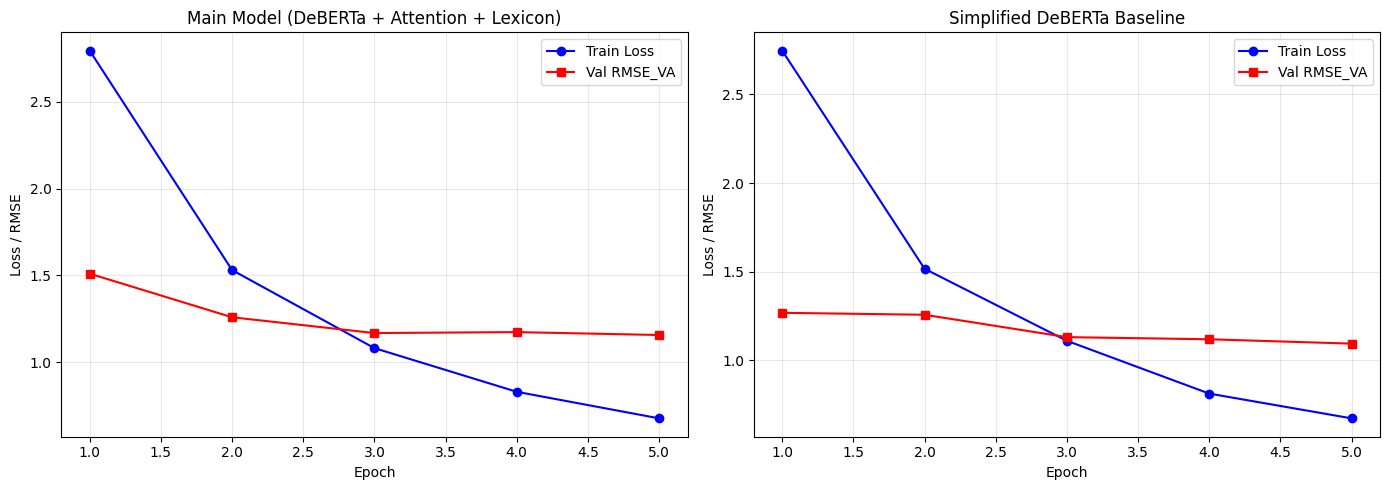

In [71]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Main model training curve
main_history = main_results['history']
epochs = [h['epoch'] for h in main_history]
train_loss = [h['train_loss'] for h in main_history]
val_rmse = [h.get('val_rmse_va', None) for h in main_history]

axes[0].plot(epochs, train_loss, 'b-', label='Train Loss', marker='o')
if val_rmse[0] is not None:
    axes[0].plot(epochs, val_rmse, 'r-', label='Val RMSE_VA', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss / RMSE')
axes[0].set_title('Main Model (DeBERTa + Attention + Lexicon)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Simplified model training curve
simple_history = simplified_results['history']
epochs_s = [h['epoch'] for h in simple_history]
train_loss_s = [h['train_loss'] for h in simple_history]
val_rmse_s = [h.get('val_rmse_va', None) for h in simple_history]

axes[1].plot(epochs_s, train_loss_s, 'b-', label='Train Loss', marker='o')
if val_rmse_s[0] is not None:
    axes[1].plot(epochs_s, val_rmse_s, 'r-', label='Val RMSE_VA', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss / RMSE')
axes[1].set_title('Simplified DeBERTa Baseline')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_curves.png', dpi=150)
plt.show()

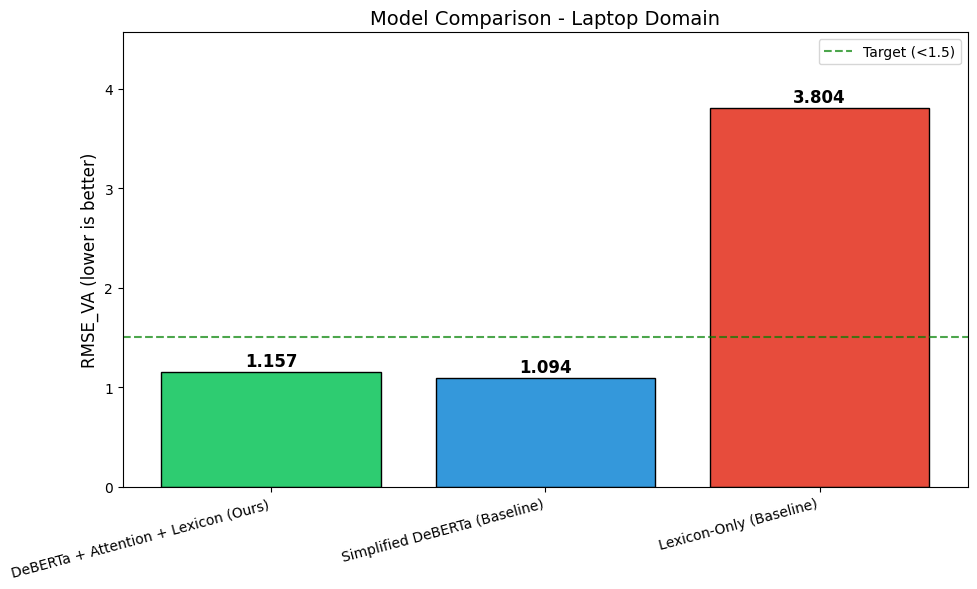

In [72]:
# Model comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

models = results_df['Model'].tolist()
rmse_values = results_df['RMSE_VA'].tolist()
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red

bars = ax.bar(models, rmse_values, color=colors, edgecolor='black')

# Add value labels
for bar, value in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{value:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('RMSE_VA (lower is better)', fontsize=12)
ax.set_title(f'Model Comparison - {DOMAIN.title()} Domain', fontsize=14)
ax.set_ylim(0, max(rmse_values) * 1.2)

# Add target line
ax.axhline(y=1.5, color='green', linestyle='--', alpha=0.7, label='Target (<1.5)')
ax.legend()

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model_comparison.png', dpi=150)
plt.show()

## 7. Prediction Examples

In [76]:
# Load best main model for predictions
best_checkpoint = OUTPUT_DIR / "checkpoints" / f"deberta_dimabsa_{DOMAIN}_best.pt"
if best_checkpoint.exists():
    main_trainer.load_checkpoint(best_checkpoint)
    print(f"Loaded best model from: {best_checkpoint}")

main_model.eval()
main_model.to(device)

# Sample predictions
sample_indices = np.random.choice(len(dev_df), min(10, len(dev_df)), replace=False)

print("\nSample Predictions vs Gold:")
print("="*80)

for idx in sample_indices:
    row = dev_df.iloc[idx]
    text = row['Text']
    aspect = row['Aspect']
    gold_v = row['Valence']
    gold_a = row['Arousal']
    
    # Tokenize
    encoding = tokenizer(
        text, aspect,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    
    # Create aspect mask
    if 'token_type_ids' in encoding:
        aspect_mask = (encoding['token_type_ids'] == 1).float()
    else:
        aspect_mask = torch.zeros_like(encoding['input_ids'], dtype=torch.float)
    
    # Get lexicon features
    lex_features = lexicon.extract_features(text, aspect).unsqueeze(0)
    
    # Predict
    with torch.no_grad():
        outputs = main_model(
            input_ids=encoding['input_ids'].to(device),
            attention_mask=encoding['attention_mask'].to(device),
            aspect_mask=aspect_mask.to(device),
            lexicon_features=lex_features.to(device)
        )
    
    pred_v = outputs['valence'].item()
    pred_a = outputs['arousal'].item()
    
    print(f"\nText: {text[:70]}..." if len(text) > 70 else f"\nText: {text}")
    print(f"Aspect: {aspect}")
    print(f"Gold:      V={gold_v:.2f}, A={gold_a:.2f}")
    print(f"Predicted: V={pred_v:.2f}, A={pred_a:.2f}")
    print(f"Error:     V={abs(pred_v-gold_v):.2f}, A={abs(pred_a-gold_a):.2f}")

Loaded best model from: ..\outputs\checkpoints\deberta_dimabsa_laptop_best.pt

Sample Predictions vs Gold:

Text: i was pleasantly suprised .
Aspect: NULL
Gold:      V=7.50, A=7.67
Predicted: V=7.93, A=7.73
Error:     V=0.43, A=0.06

Text: there is something about their atmosphere that makes me come back near...
Aspect: atmosphere
Gold:      V=5.67, A=5.50
Predicted: V=7.35, A=7.17
Error:     V=1.68, A=1.67

Text: it ' s the perfect spot for a romantic date for 2 or a secret rendezvo...
Aspect: spot
Gold:      V=7.75, A=8.00
Predicted: V=7.72, A=7.73
Error:     V=0.03, A=0.27

Text: paul , the maitre d ' , was totally professional and always on top of ...
Aspect: paul
Gold:      V=8.17, A=8.33
Predicted: V=7.53, A=7.50
Error:     V=0.64, A=0.83

Text: the drinks are always well made and wine selection is fairly priced .
Aspect: drinks
Gold:      V=7.50, A=7.50
Predicted: V=7.31, A=7.30
Error:     V=0.19, A=0.20

Text: we did have the same waiter the second time , so maybe the service i

## 8. Summary and Conclusions

In [81]:
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\nDataset: {DOMAIN.title()} domain")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(dev_df)}")

print(f"\nModel Performance (RMSE_VA - lower is better):")
for _, row in results_df.iterrows():
    print(f"  {row['Model']}: {row['RMSE_VA']:.4f}")

best_model_idx = results_df['RMSE_VA'].idxmin()
print(f"\nBest Model: {results_df.loc[best_model_idx, 'Model']}")
print(f"Best RMSE_VA: {results_df.loc[best_model_idx, 'RMSE_VA']:.4f}")

# Improvement calculation
main_rmse = results_df[results_df['Model'].str.contains('Ours')]['RMSE_VA'].values[0]
lexicon_rmse = results_df[results_df['Model'].str.contains('Lexicon-Only')]['RMSE_VA'].values[0]
simplified_rmse = results_df[results_df['Model'].str.contains('Simplified')]['RMSE_VA'].values[0]

print(f"\nImprovement over Lexicon-Only: {(lexicon_rmse - main_rmse) / lexicon_rmse * 100:.1f}%")
print(f"Improvement over Simplified DeBERTa: {(simplified_rmse - main_rmse) / simplified_rmse * 100:.1f}%")

print("\n" + "="*60)
print("Key Findings:")
print("1. Simplified DeBERTa baseline achieved the best validation RMSE_VA in our runs")
print("2. The full DeBERTa+Attention+Lexicon model did not outperform the simplified variant")
print("3. Lexicon features provide modest benefits but are not sufficient alone")
print("4. Further tuning (learning rate, batch size, output scaling) may improve the full model; prioritize lightweight models for deployment")


SUMMARY

Dataset: Laptop domain
Training samples: 2796
Validation samples: 311

Model Performance (RMSE_VA - lower is better):
  DeBERTa + Attention + Lexicon (Ours): 1.1571
  Simplified DeBERTa (Baseline): 1.0940
  Lexicon-Only (Baseline): 3.8040

Best Model: Simplified DeBERTa (Baseline)
Best RMSE_VA: 1.0940

Improvement over Lexicon-Only: 69.6%
Improvement over Simplified DeBERTa: -5.8%

Key Findings:
1. Simplified DeBERTa baseline achieved the best validation RMSE_VA in our runs
2. The full DeBERTa+Attention+Lexicon model did not outperform the simplified variant
3. Lexicon features provide modest benefits but are not sufficient alone
4. Further tuning (learning rate, batch size, output scaling) may improve the full model; prioritize lightweight models for deployment


In [78]:
# Save results
results_df.to_csv(OUTPUT_DIR / f'results_{DOMAIN}.csv', index=False)
print(f"\nResults saved to: {OUTPUT_DIR / f'results_{DOMAIN}.csv'}")

# Save training history
import json
with open(OUTPUT_DIR / f'training_history_{DOMAIN}.json', 'w') as f:
    json.dump({
        'main_model': main_results,
        'simplified_model': simplified_results,
        'lexicon_metrics': {k: float(v) if isinstance(v, (np.floating, np.integer)) else v 
                           for k, v in lexicon_metrics.items()}
    }, f, indent=2, default=str)
print(f"Training history saved to: {OUTPUT_DIR / f'training_history_{DOMAIN}.json'}")


Results saved to: ..\outputs\results_laptop.csv
Training history saved to: ..\outputs\training_history_laptop.json
